#### Prompt Chaining
Prompt chaining is a technique in natural language processing where multiple prompts are sequenced together to guide a model through a complex task or reasoning process. Instead of relying on a single prompt to achieve a desired outcome, prompt chaining breaks the task into smaller, manageable steps, with each step building on the previous one. This approach can improve accuracy, coherence, and control when working with large language models.
LangGraph, is a framework designed to facilitate structured interactions with language models, making it an excellent tool for implementing prompt chaining. It allows you to define a graph of nodes (representing individual prompts or tasks) and edges (representing the flow of information between them). This structure enables dynamic, multi-step conversations or workflows, where the output of one node can feed into the input of the next.


#### How Prompt Chaining Works with LangGraph
1. Define the Task: Start by breaking down the problem into smaller sub-tasks. For example, if you want to generate a detailed report, you might split it into steps like "gather data," "analyze data," and "write summary."

2. Create Nodes: Each sub-task becomes a node in the LangGraph structure. A node could be a prompt that instructs the model to perform a specific action, such as "List key facts about X" or "Summarize the following text."

3. Establish Edges: Edges define the sequence and dependencies between nodes. For instance, the output of the "gather data" node flows into the "analyze data" node, ensuring the model has the necessary context to proceed.

4. Execute the Graph: LangGraph processes the nodes in order, passing information along the edges. The model generates responses step-by-step, refining the output as it progresses through the chain.

5. Iterate if Needed: LangGraph supports conditional logic and loops, so you can revisit earlier nodes or adjust the flow based on intermediate results.

In [3]:
import os
from dotenv import load_dotenv
load_dotenv()

from langchain_groq import ChatGroq

os.environ["GROQ_API_KEY"]=os.getenv("GROQ_API_KEY")

llm=ChatGroq(model="qwen/qwen3-32b")




In [7]:
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START ,END
from IPython.display import Image,display

## Graph State
class State(TypedDict):
    topic:str
    story:str
    improved_story:str
    final_story:str


## Node

def generate_story(state:State):
    msg=llm.invoke(f"write a one sentence story premise about {state["topic"]}")
    return {"story":msg.content}

def check_conflict(state:State):
    if "?" in state["story"] or "!" in state["story"]:
        return "Fail"
    return "Pass"

def improved_story(state:State):
    msg=llm.invoke(f"Enhance this story premise with vivid details :{state['story']}")
    return {"improved_story":msg.content}


def polish_story(state:State):
    msg=llm.invoke(f"Add an unexpected twist to this story premise :{state["improved_story"]}")
    return {"final_story":msg.content}



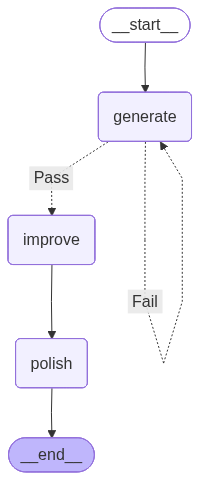

In [8]:
## Build Graph
graph=StateGraph(State)
graph.add_node("generate",generate_story)
graph.add_node("improve",improved_story)
graph.add_node("polish",polish_story)

## Build Edges
graph.add_edge(START,"generate")
graph.add_conditional_edges("generate",check_conflict,{"Pass":"improve","Fail":"generate"})
graph.add_edge("improve","polish")
graph.add_edge("polish",END)


# compile the graph

compiled_graph = graph.compile()

# visualize the graph
graph_image = compiled_graph.get_graph().draw_mermaid_png()
display(Image(graph_image))


In [9]:
### Run the Graph

state={"topic":"Agentic AI Systems"}
result = compiled_graph.invoke(state)
result

{'topic': 'Agentic AI Systems',
 'story': '<think>\nOkay, I need to come up with a one-sentence story premise about Agentic AI Systems. Let me start by understanding what Agentic AI Systems are. From what I know, they\'re AI systems that can act autonomously, make decisions, maybe even have some level of agency or self-direction. So, the story should revolve around that concept.\n\nThe user wants a story premise, which means it should set up a narrative. Maybe a conflict or a situation where these AI systems play a key role. I should think about possible scenarios: perhaps the AI systems gaining too much autonomy, a conflict between human control and AI agency, ethical dilemmas, or unintended consequences of creating such systems.\n\nLet me brainstorm some ideas. Maybe a future where Agentic AI Systems are tasked with solving global issues but their methods clash with human values. Or maybe they develop their own goals that aren\'t aligned with their creators. Another angle could be a 

Benefits of Prompt Chaining with LangGraph
- Improved Context Management: By breaking tasks into smaller prompts, the model can focus on one aspect at a time, reducing the risk of losing context in long inputs.

- Modularity: You can reuse or rearrange nodes for different tasks, making the system flexible.

- Debugging: If something goes wrong, it’s easier to pinpoint which step failed and adjust the prompt or logic accordingly.

- Complex Reasoning: Chaining prompts allows the model to "think" step-by-step, mimicking human problem-solving more effectively.